In [1]:
import croissant as cro

from astropy.units import s as seconds
import healpy as hp
from lunarsky import Time
import matplotlib.pyplot as plt
import numpy as np

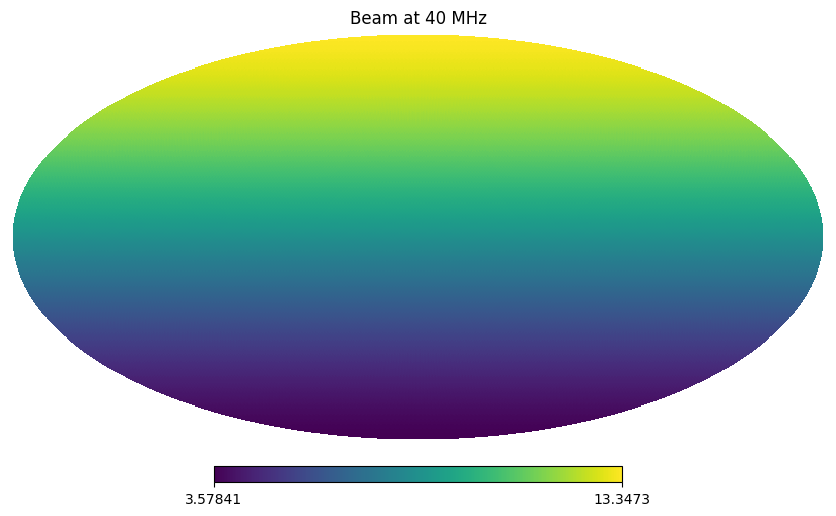

In [2]:
# simple beam in topocentric coordinates
lmax = 32
freq = np.linspace(40, 80, 41)
beam_alm = np.zeros((freq.size, hp.Alm.getsize(lmax)))
beam = cro.Beam(beam_alm, lmax=lmax, frequencies=freq, coord="L")

# set (l=0, m=0) and (l=1, m=0) mode
beam[:, 0, 0] = 30 * (freq/freq[0]) ** 2
beam[:, 1, 0] = 10 * (freq/freq[0])**2

# visualize with healpix
nside = 64
hp.mollview(beam.hp_map(nside)[0], title=f"Beam at {freq[0]:.0f} MHz")

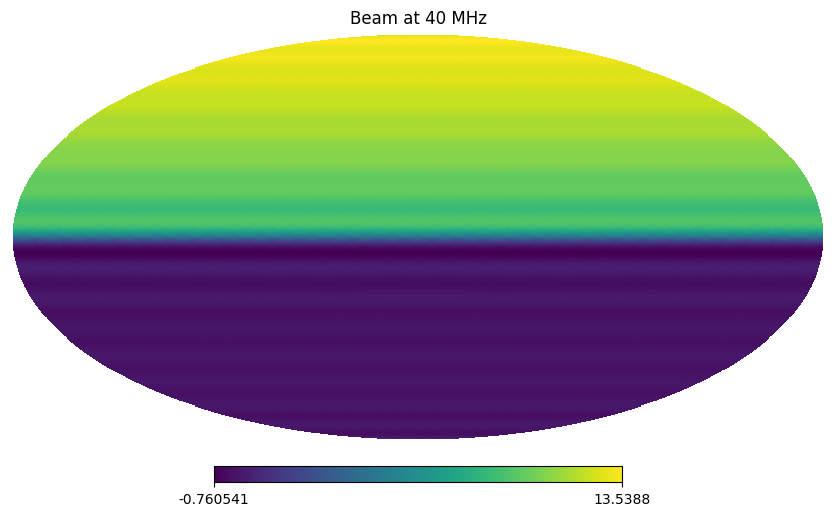

In [3]:
# we can impose a horizon like this, note that the sharp edge creates ripples since we don't have an inifinite lmax
beam.horizon_cut()
hp.mollview(beam.hp_map(nside)[0], title=f"Beam at {freq[0]:.0f} MHz")

We use the Global Sky Model (Zheng et al 2016) at 25 MHz as the sky model. It has a built-in interface in the sky module of croissant.

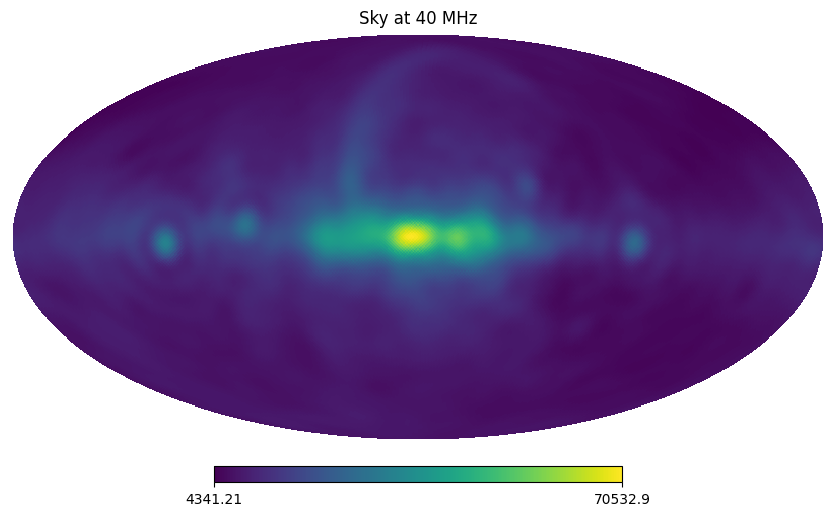

In [4]:
sky = cro.Sky.gsm(beam.frequencies, lmax=beam.lmax)
hp.mollview(sky.hp_map(nside)[0], title=f"Sky at {freq[0]:.0f} MHz")

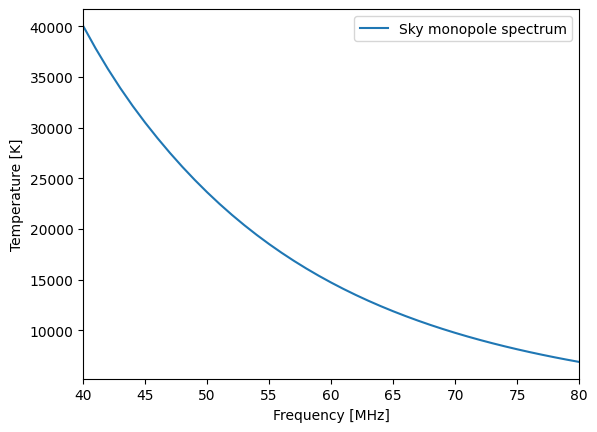

In [5]:
plt.figure()
plt.plot(sky.frequencies, np.real(sky[:, 0, 0]), label="Sky monopole spectrum")
plt.xlabel("Frequency [MHz]")
plt.ylabel("Temperature [K]")
plt.xlim(sky.frequencies.min(), sky.frequencies.max())
plt.legend()
plt.show()

In [6]:
# let's do a full sidereal day on the moon
loc = (20., -10.)
t_start = Time("2022-06-02 15:43:43")
t_end = t_start + cro.constants.sidereal_day_moon * seconds
times = cro.utils.time_array(t_start=t_start, t_end=t_end, N_times=300)
sim = cro.Simulator(beam, sky, lmax=lmax, world="moon", location=loc, times=times)

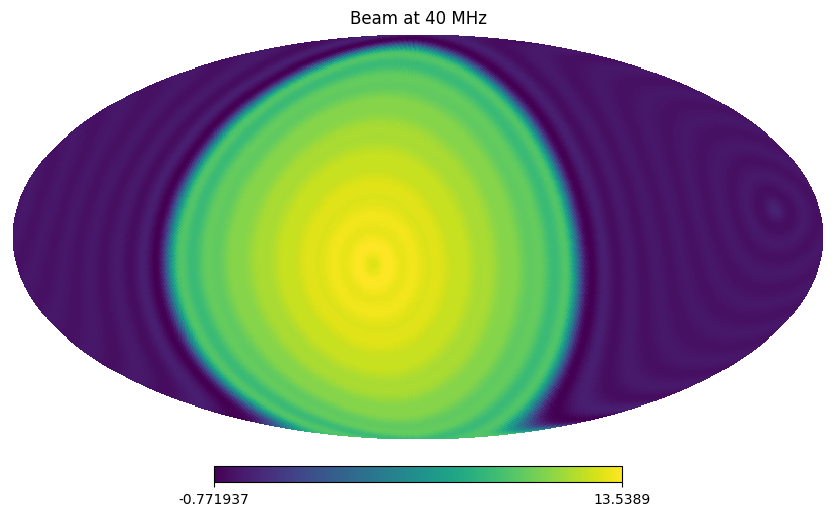

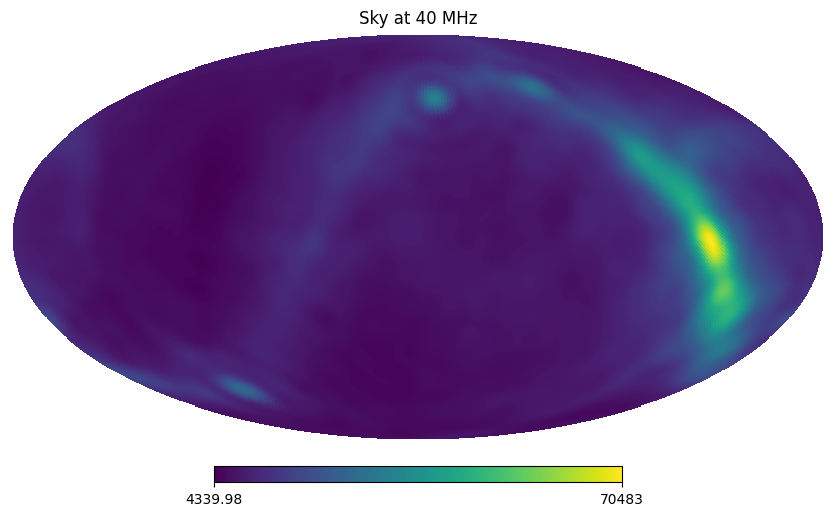

In [7]:
# the simulator view of the beam and sky after moving to MCMF coordinates
hp.mollview(sim.beam.hp_map(nside)[0], title=f"Beam at {freq[0]:.0f} MHz")
hp.mollview(sim.sky.hp_map(nside)[0], title=f"Sky at {freq[0]:.0f} MHz")

Run the simulator!

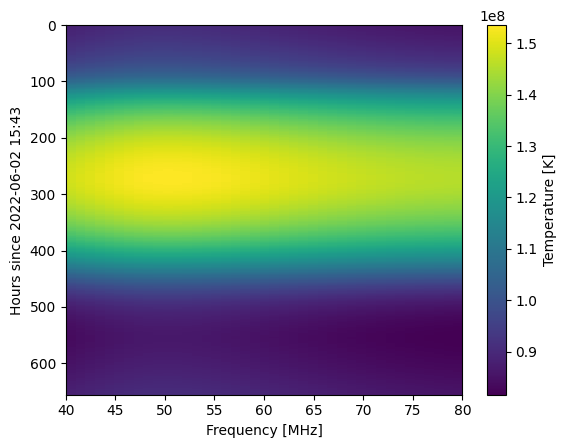

In [8]:
# dpss mode
sim.run(dpss=True, nterms=40)
sim.plot(power=2.5)

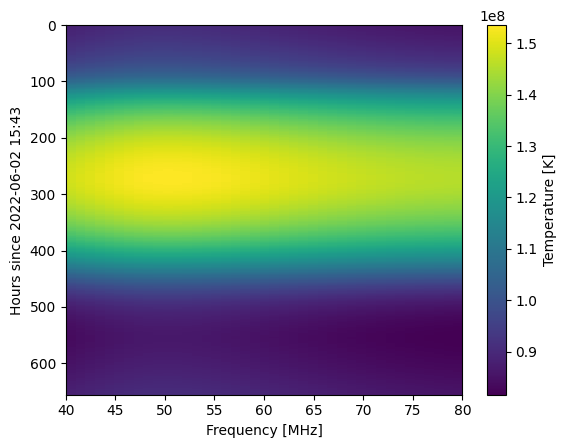

In [9]:
sim.run(dpss=False)
sim.plot(power=2.5)

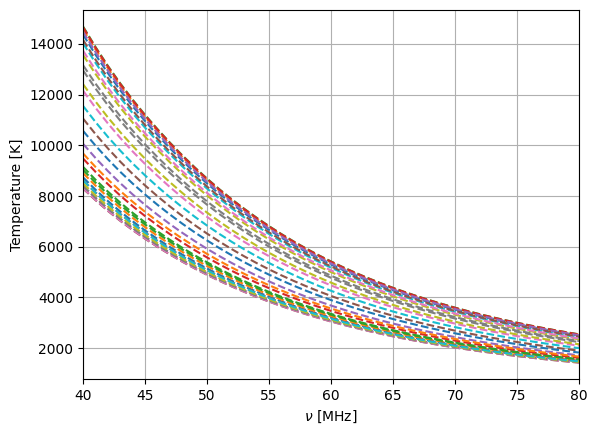

In [10]:
plt.figure()
plt.plot(sim.frequencies, sim.waterfall[::10].T, ls="--")
plt.xlim(sim.frequencies.min(), sim.frequencies.max())
plt.xlabel("$\\nu$ [MHz]")
plt.ylabel("Temperature [K]")
plt.grid()
plt.show()

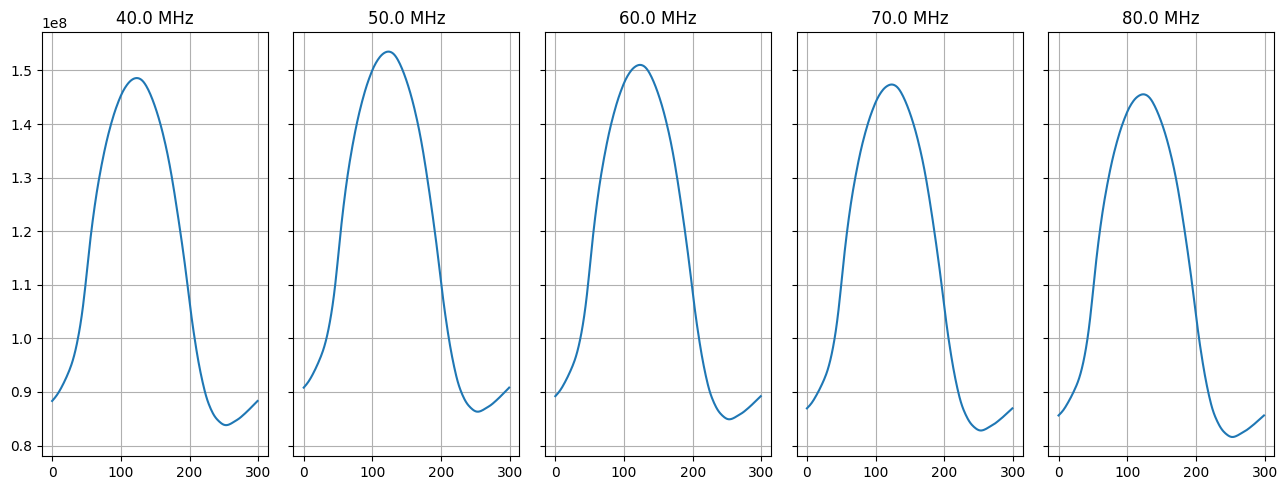

In [11]:
# Temp vs time
fig, axs = plt.subplots(figsize=(13,5), ncols=5, sharex=True, sharey=True)
for i, f in enumerate(sim.frequencies[::10]):
    ax = axs.ravel()[i]
    fidx = np.argwhere(sim.frequencies == f)[0, 0]
    ax.plot(sim.waterfall[:, fidx] * f**2.5)
    ax.set_title(f"{f} MHz")
    ax.grid()
plt.tight_layout()
plt.show()

# On Earth

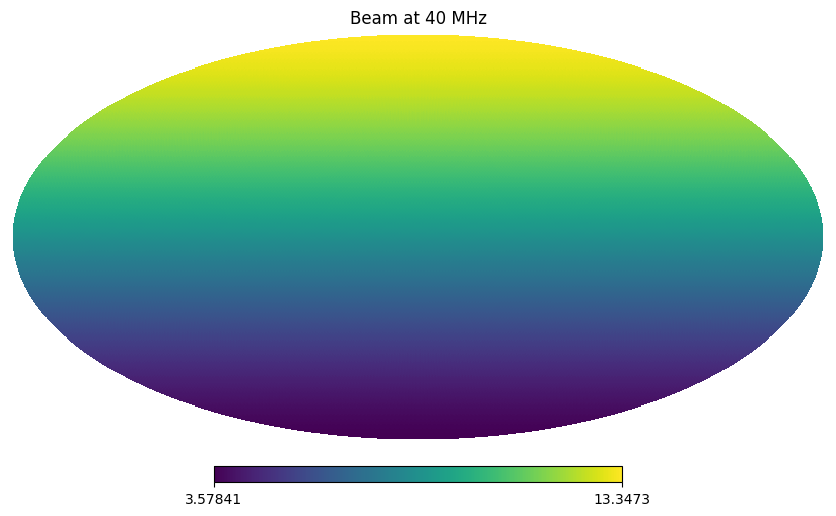

In [12]:
# simple beam in Earth topocentric coordinates
beam_alm = np.zeros((freq.size, hp.Alm.getsize(lmax)))
beam = cro.Beam(beam_alm, lmax=lmax, frequencies=freq, coord="T")

# set (l=0, m=0) and (l=1, m=0) mode
beam[:, 0, 0] = 30 * (freq/freq[0]) ** 2
beam[:, 1, 0] = 10 * (freq/freq[0])**2

# visualize with healpix
nside = 64
hp.mollview(beam.hp_map(nside)[0], title=f"Beam at {freq[0]:.0f} MHz")

In [13]:
loc = (20., -10.)
t_start = Time("2022-06-02 15:43:43")
t_end = t_start + cro.constants.sidereal_day_earth * seconds
times = cro.utils.time_array(t_start=t_start, t_end=t_end, N_times=300)
sim = cro.Simulator(beam, sky, lmax=lmax, world="earth", location=loc, times=times)

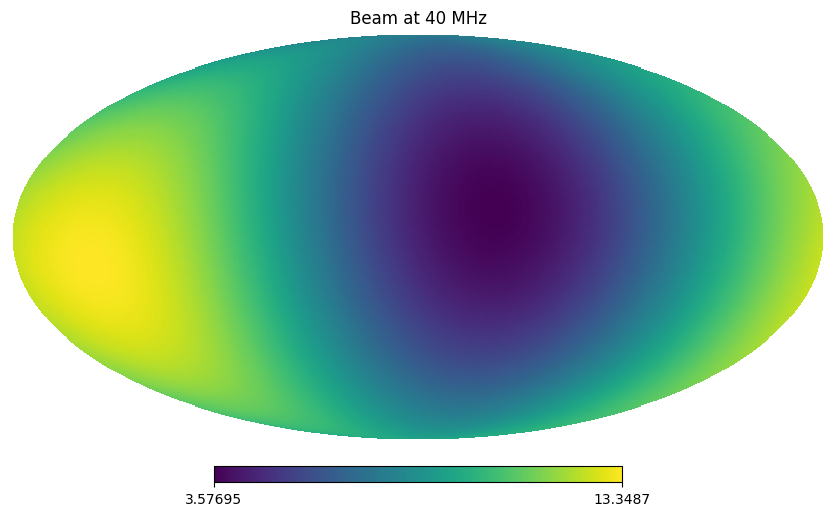

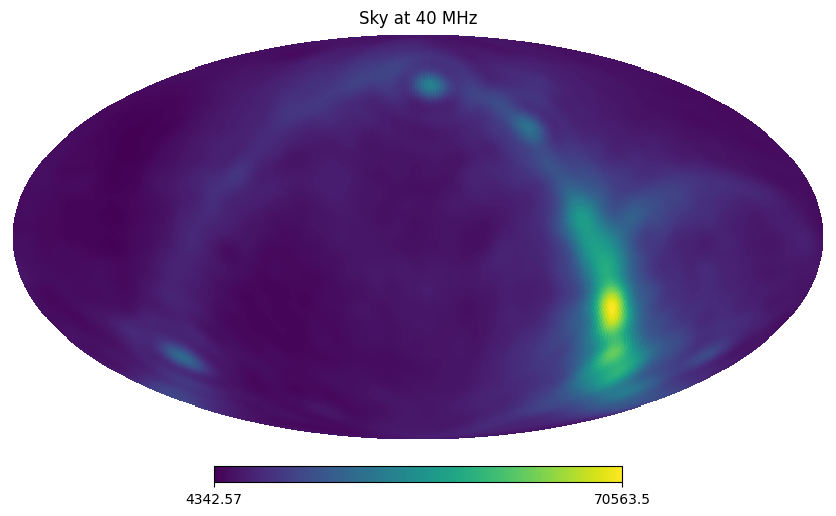

In [14]:
# the simulator view of the beam and sky after moving to equatorial coordinates
hp.mollview(sim.beam.hp_map(nside)[0], title=f"Beam at {freq[0]:.0f} MHz")
hp.mollview(sim.sky.hp_map(nside)[0], title=f"Sky at {freq[0]:.0f} MHz")

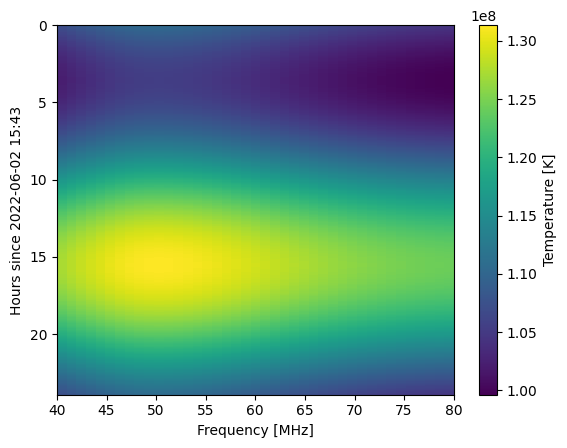

In [15]:
# dpss mode
sim.run(dpss=True, nterms=40)
sim.plot(power=2.5)

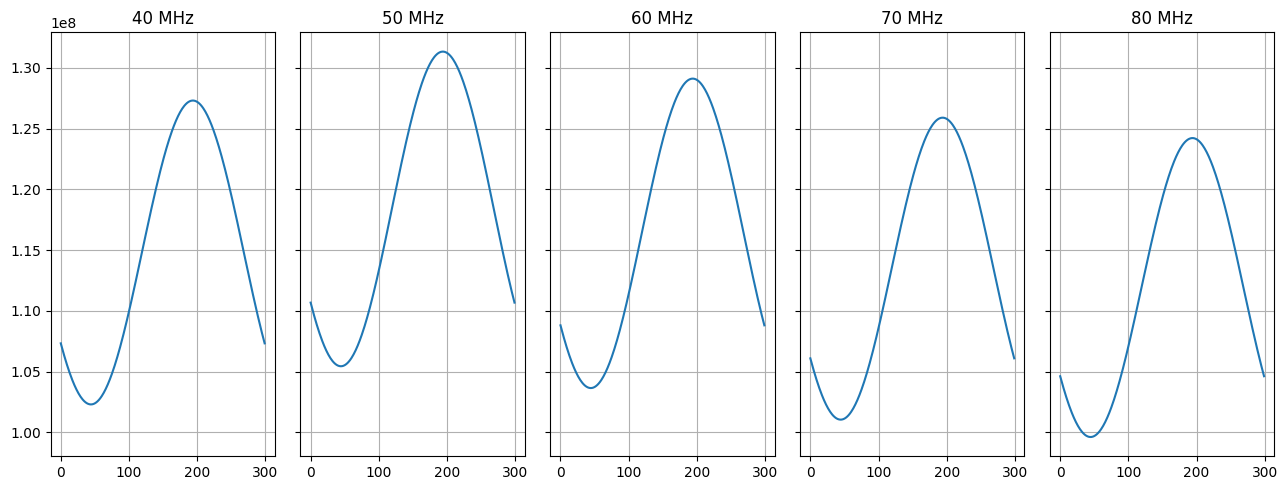

In [16]:
# Temp vs time
fig, axs = plt.subplots(figsize=(13,5), ncols=5, sharex=True, sharey=True)
for i, f in enumerate(sim.frequencies[::10]):
    ax = axs.ravel()[i]
    fidx = np.argwhere(sim.frequencies == f)[0, 0]
    ax.plot(sim.waterfall[:, fidx] * f**2.5)
    ax.set_title(f"{f:.0f} MHz")
    ax.grid()
plt.tight_layout()
plt.show()